In [1]:
import os
import tensorflow as tf
from tensorflow.keras.layers import *
import tensorflow.keras.regularizers as reg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image, display
import datetime
import numpy as np
print(tf.config.list_physical_devices('GPU'))

%load_ext tensorboard

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


lets view the data! 

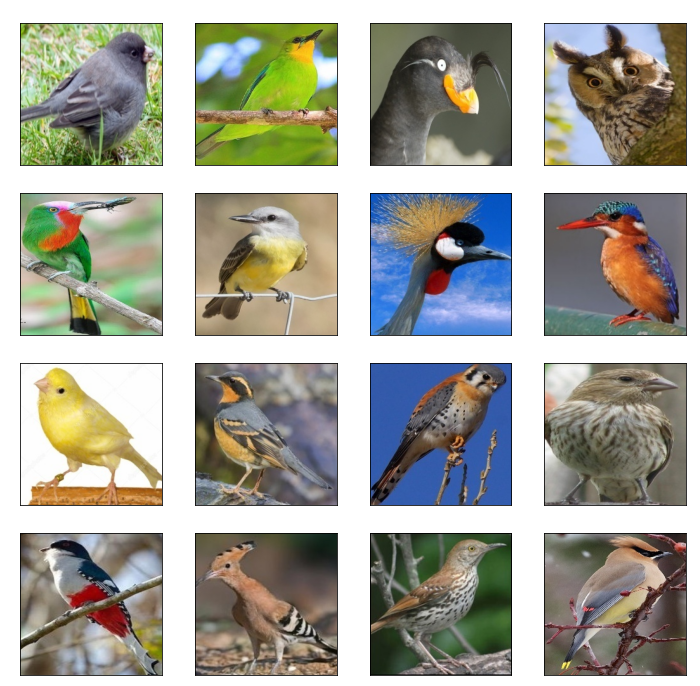

In [2]:
from random import shuffle
sample_files = []
path = './285 birds/valid/'
for r,d,f in os.walk(path):
    for dir in d:
        for r1, d1, f1 in os.walk(os.path.join(path, dir)):
            sample_files.extend([path + dir + '/' + _ for _ in f1])


shuffle(sample_files)
bird_types = sample_files[:16]
imgs = [mpimg.imread(f) for f in bird_types]
fig, axs = plt.subplots(4, 4, figsize = (12,12))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(imgs[i])
    ax.set_title(bird_types[i][18:].strip('.jpg'), c = 'w')
    ax.set_xticks([])
    ax.set_yticks([])


as you can see the sample images are pretty tightly cropped, but there is some room on the sides. Data may be lost during transformations but that is ok, these transformations will serve as powerful tools in preventing overfitting. 

I will be using keras ImageDataGenerator to apply these transformations. This is a powerfull tool that allows you to quickly make image transformation and get them into your data pipeline.

[ImageDataGenerator Docs](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

## I will be applying the following transformations: 

Rescale: fit the image between 1 and 0, this is a normalization step. It is a simple transformation can be done so the network does not have to worry about it.

Rotation: Often in the wild, birds and cameras alike are at variable orientations. Applying a random rotation to each image will account for this. Since (almost) all birds are upright when standing and horizontal a small rotation of 15 degrese will suffice

Horizontal flip: Perhaps the easiest and best way to expand image data is to mirror around the Y axis. A veritcle flip can be good in some situiations but an upside down bird isn't really a concern 

Horizontal and Veritcle shifts: This simply shifts the image a random amount of pixels. Thus teaching the network to look at the entire image rather than just the center or another location. Since the images are tightly cropped around the bird, we will only shift by maximum 8% of the image.

Brightness shifting: Not all pictures have perfect exposure, some are over and under exposed. Augmenting the data to be darker or lighter will account for this. Range (.8, 1.2) will be used. 

Zoom: Randoms zooms recrop the image so the network learns to be robust against image sizes. Range (.9, 1.1) will be used.

Black Boxes: Applying randomly placed black boxes on the images will provide a simalar effect to dropout inside the network. Forcing the network not to rely on any particular datapoint or feature. This is not a default parameter of ImageDataGenertor but we can apply it by passing a function to the preprocessing_function parameter of ImageDataGenerator. 


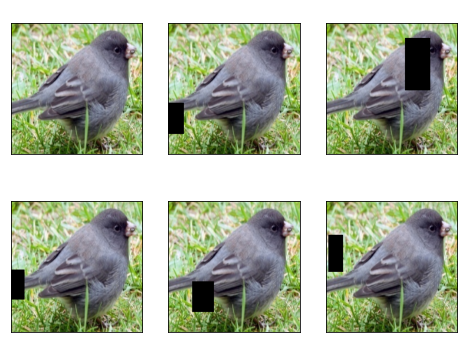

In [3]:
class Blackbox():
    def __init__(self, height_range, width_range):
        self.height_range = height_range
        self.width_range = width_range
    
    def __call__(self, image):
        shape = image.shape
        center_x, center_y = np.random.rand(2)
        center_x *= shape[1]
        center_y *= shape[0]
        height = np.random.uniform(self.height_range[0], self.height_range[1]) * shape[0]
        width = np.random.uniform(self.width_range[0], self.width_range[1]) * shape[1]
        low_x, high_x = int(center_x - width/2) , int(center_x + width/2)
        low_y, high_y = int(center_y - height/2), int(center_y + height/2)
        low_x, high_x, low_y, high_y = [max(x, 0) for x in [low_x, high_x, low_y, high_y]]
        mask = np.ones(shape, dtype= type(image[0][0][0]))
        mask[low_y: high_y, low_x: high_x, :] = 0
        return image * mask


f = Blackbox((.2, .4), (.1, .2))

img = mpimg.imread(bird_types[0])
fig, axs = plt.subplots(2, 3, figsize = (8, 6))
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])
axs[0, 0].set_title('Original', color = 'w')
axs[0, 0].imshow(img)
for ax in axs.flatten()[1:]:
    ax.imshow(f(img))
    ax.set_xticks([])
    ax.set_yticks([])


        

Found 40930 images belonging to 285 classes.
Found 1425 images belonging to 285 classes.
Found 1425 images belonging to 285 classes.


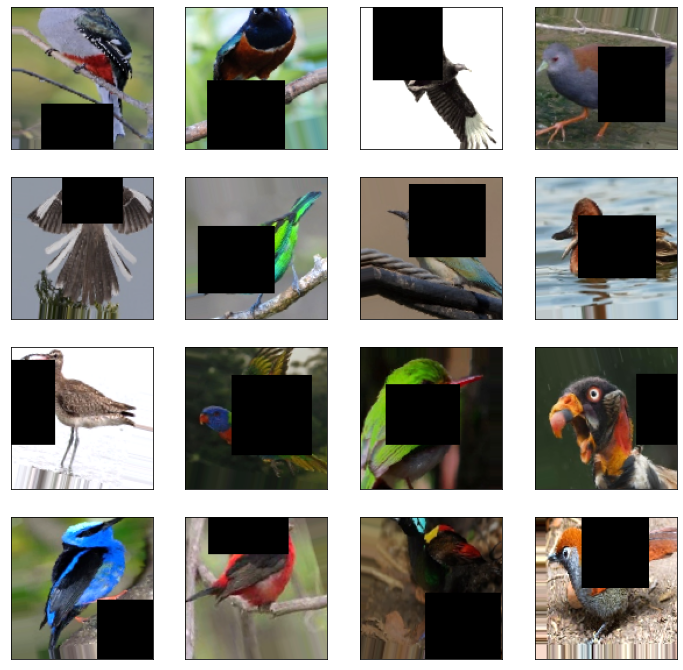

In [4]:
batch_size = 64

rotation = 15
shift_range = (-.08, .08)
brightness_range = (.8, 1.2)
zoom_range = (.9, 1.1)
target_size = (122, 122)
black_box = Blackbox((.4, .6), (.4, .6))

train_datagen = ImageDataGenerator(
    rescale = 1./255., 
    zoom_range = zoom_range,
    width_shift_range = shift_range,
    height_shift_range = shift_range,
    brightness_range= brightness_range,
    rotation_range= rotation,
    preprocessing_function = black_box,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(
    rescale = 1./255., 
    zoom_range = zoom_range,
    width_shift_range = shift_range,
    height_shift_range = shift_range,
    brightness_range= brightness_range,
    rotation_range= rotation,
    preprocessing_function = black_box,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(
    rescale = 1./255.)

train_gen = train_datagen.flow_from_directory(
        './285 birds/train',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')

val_gen = val_datagen.flow_from_directory(
        './285 birds/valid',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')

test_gen = test_datagen.flow_from_directory(
        './285 birds/test',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical')

fig, axs = plt.subplots(4, 4, figsize = (12,12))
img, label = train_gen.next()
for i, ax in enumerate(axs.flatten()):
    ax.imshow(img[i])
    ax.set_xticks([])
    ax.set_yticks([])

The data looks good, the images are definitly augemented which will force the network to learn the identify the birds based on a vast amount of features. This will help prevent overfitting. 

Lets get the models ready!

I am using inception net v3, this is a pretrained model that already knows how to idenitfy key features. This particular model was trained on imagenet, a pretty broad data set. The filters are already trained to recognize images. This will save my little gtx 1050 a lot of time and effort. 

Inception is a pretty cool idea. In essence: different features have different sizes so it is benifical to run multiple sized filters when convoluting. 

[InceptionNetV3 Paper](https://arxiv.org/abs/1512.00567v3)

In [5]:

input_shape = (122, 122, 3)

base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape = input_shape, include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

inputs = Input(shape = input_shape)
x = base_model(inputs)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dropout(.2)(x)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(.2)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(.1)(x)
x = Dense(285, activation = 'softmax')(x)

model = tf.keras.Model(inputs = inputs, outputs = x)
model.compile(optimizer=tf.keras.optimizers.Adam(beta_1 = .9),
              loss='categorical_crossentropy',
              metrics=['acc'],
              )

print(model.summary())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 122, 122, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
batch_normalization_94 (Batc (None, 2, 2, 2048)        8192      
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0     

Lets figure out learning rate, we will start very low and move upwards. Once loss starts to diverge we know we have moved too far.

In [6]:
!rm -rf ./logs/

class LRTestSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, initial_learning_rate, base, exponent_scale):
    self.initial_learning_rate = initial_learning_rate
    self.base = base
    self.exponent_scale = exponent_scale

  @tf.function
  def __call__(self, step):
    lr = self.initial_learning_rate * self.base**(step/self.exponent_scale)
    if step < 640:
      return tf.constant(1e-2, dtype=lr.dtype)
    else:
      return lr
lr = LRTestSchedule(1e-4, 10, 1000)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, update_freq = 'batch')

modeltest = tf.keras.Model(inputs = inputs, outputs = x)
modeltest.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr, epsilon = 1),
              loss='categorical_crossentropy',
              metrics=['acc'],
              )

history = modeltest.fit(train_gen,
                    validation_data = val_gen,
                    epochs=8,
                    callbacks=[tensorboard_cb],
                    verbose=1)


Epoch 1/8
640/640 [==============================] - 229s 348ms/step - loss: 5.6438 - acc: 0.0250 - val_loss: 4.8193 - val_acc: 0.1046
Epoch 2/8
640/640 [==============================] - 235s 367ms/step - loss: 5.0693 - acc: 0.0691 - val_loss: 4.6628 - val_acc: 0.1256
Epoch 3/8
640/640 [==============================] - 248s 387ms/step - loss: 4.7933 - acc: 0.0954 - val_loss: 4.0354 - val_acc: 0.1979
Epoch 4/8
640/640 [==============================] - 240s 375ms/step - loss: 4.1020 - acc: 0.1700 - val_loss: 3.1143 - val_acc: 0.3088
Epoch 5/8
640/640 [==============================] - 231s 360ms/step - loss: 3.6205 - acc: 0.2331 - val_loss: 3.0779 - val_acc: 0.3158
Epoch 6/8
431/640 [===================>..........] - ETA: 1:17 - loss: 3.9876 - acc: 0.1887

Loss seems to decrease the most when learning rate is around e-2 range. Lets start with 2e-2 and half that by 20 epochs (ish). 

In [7]:
!rm -rf ./logs/

lr = tf.keras.optimizers.schedules.ExponentialDecay(1e-2, 640, .7)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, update_freq = 'batch')

model = tf.keras.Model(inputs = inputs, outputs = x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = lr, epsilon = .1),
              loss='categorical_crossentropy',
              metrics=['acc'],
              )
history = model.fit(train_gen,
                    validation_data = val_gen,
                    epochs=20,
                    callbacks=[tensorboard_cb],
                    verbose=1)

model.save_weights('./birdception_check/epoch20')

Epoch 1/20


KeyboardInterrupt: 

The val accuracy seems to stagate and the loss is decresing slowly, I believe this is caused by a large step size. Since relu is constant for all negative values, too large of a step size can put weights too far into the negative. Thus, causing the activavtion to almost always be negative, giving back propagation (or whatever varient) no gradient to grab onto. Swish will provide some gradient for negative activations put keep the general form of relu

[Swish activation function paper](https://arxiv.org/pdf/1710.05941.pdf)